In [1]:
!pip install torch --quiet
!pip install gpytorch --quiet

In [14]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import math
import torch
import gpytorch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.gaussian_process as gp


from sklearn.preprocessing import OneHotEncoder


In [15]:
training_data = pd.read_csv('../../data/2-uw_layer1_trainingdata.csv')

In [16]:
training_data.head()

,BOREHOLE_ID,BOREHOLE_NAME,BOREHOLE_TYPE,BOREHOLE_DEPTH_FT,ELEVATION_FT,LATITUDE,LONGITUDE,LAYER_NUMBER,TOP_DEPTH_FT,BOTTOM_DEPTH_FT,USCS,SIMPLE_USCS,LAYER_THICKNESS_FT,geometry,MAPPED_UNIT,SLOPE,ROUGHNESS
0,7138,B-1,Geotechnical,20.3,167.8,47.656719,-122.305728,1,0.0,1.0,SP,S,1.0,POINT (-122.30572826225551 47.65671910427262),Qvt,3.668571,18.199593
1,7143,B-1-92,Geotechnical,48.5,123.2,47.653642,-122.306837,1,0.0,1.0,ML,M,1.0,POINT (-122.30683733651996 47.653641992071),Qvt,2.222722,10.232103
2,7144,B-2-92,Geotechnical,42.5,122.9,47.653766,-122.306468,1,0.0,1.0,ML,M,1.0,POINT (-122.30646818846918 47.653765607387086),Qvt,1.996012,9.385303
3,7145,B-3-92,Geotechnical,43.0,117.3,47.653256,-122.306638,1,0.0,1.0,ML,M,1.0,POINT (-122.30663757111256 47.65325573559402),Qvt,3.011285,14.187020
4,7146,B-4-92,Geotechnical,43.0,123.4,47.653709,-122.306259,1,0.0,0.5,SM,S,0.5,POINT (-122.30625929325416 47.65370851868135),Qvt,1.996012,9.385303


In [17]:
#training_data.boxplot(column='LAYER_THICKNESS_FT', by='USCS')

In [18]:
#training_data.boxplot(column='SLOPE', by='USCS')

In [19]:
#training_data.boxplot(column='ROUGHNESS', by='USCS')

In [20]:
#training_data.boxplot(column='LAYER_THICKNESS_FT', by='SIMPLE_USCS')

In [21]:
#training_data.boxplot(column='SLOPE', by='SIMPLE_USCS')

In [22]:
#training_data.boxplot(column='ROUGHNESS', by='SIMPLE_USCS')

one-hot-encoding for MAPPED_UNIT feature

In [35]:
# with sklearn function
enc = OneHotEncoder(handle_unknown='ignore')
encoded_mapped_unit = enc.fit_transform(training_data[['MAPPED_UNIT']]).toarray()
pd.DataFrame(encoded_mapped_unit.tolist())

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [30]:
# with pandas, seems simpler
training_data_encoded = pd.get_dummies(training_data, columns = ['MAPPED_UNIT'], dtype=int)
training_data_encoded

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [12]:
training_data_encoded.keys()

Index(['BOREHOLE_ID', 'BOREHOLE_NAME', 'BOREHOLE_TYPE', 'BOREHOLE_DEPTH_FT',
       'ELEVATION_FT', 'LATITUDE', 'LONGITUDE', 'LAYER_NUMBER', 'TOP_DEPTH_FT',
       'BOTTOM_DEPTH_FT', 'USCS', 'SIMPLE_USCS', 'LAYER_THICKNESS_FT',
       'geometry', 'SLOPE', 'ROUGHNESS', 'MAPPED_UNIT_Qal', 'MAPPED_UNIT_Ql',
       'MAPPED_UNIT_Qp', 'MAPPED_UNIT_Qpf', 'MAPPED_UNIT_Qpo',
       'MAPPED_UNIT_Qva', 'MAPPED_UNIT_Qvi', 'MAPPED_UNIT_Qvr',
       'MAPPED_UNIT_Qvt', 'MAPPED_UNIT_Qw', 'MAPPED_UNIT_wtr'],
      dtype='object')

In [99]:
# for the classification model
X_c = training_data_encoded.drop(columns=['BOREHOLE_ID', 'BOREHOLE_NAME', 'BOREHOLE_TYPE', 'BOREHOLE_DEPTH_FT',
       #'ELEVATION_FT', 'LATITUDE', 'LONGITUDE', 'LAYER_NUMBER', 'TOP_DEPTH_FT',
       'BOTTOM_DEPTH_FT', 'SIMPLE_USCS', 'USCS', 'LAYER_THICKNESS_FT',
       'geometry'])
y_c = training_data_encoded['SIMPLE_USCS']

# for the regression model
X_r = training_data_encoded.drop(columns=['BOREHOLE_ID', 'BOREHOLE_NAME', 'BOREHOLE_TYPE', 'BOREHOLE_DEPTH_FT',
       #'ELEVATION_FT', 'LATITUDE', 'LONGITUDE', 'LAYER_NUMBER', 'TOP_DEPTH_FT',
       'BOTTOM_DEPTH_FT', 'SIMPLE_USCS', 'USCS', 'LAYER_THICKNESS_FT',
       'geometry'])
y_r = training_data_encoded['LAYER_THICKNESS_FT']

In [100]:


X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=42)


X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r, y_r, test_size=0.2, random_state=42)


In [101]:
myGPR = gp.GaussianProcessRegressor()

In [102]:
myGPC = gp.GaussianProcessClassifier()

In [103]:
myGPR.fit(X_train_r, y_train_r)

GaussianProcessRegressor()

In [104]:
y_predicted_r = myGPR.predict(X_test_r)

In [105]:
y_test_r.shape

(102,)

(array([ 2.,  0.,  2.,  3., 22., 49., 12.,  6.,  2.,  4.]),
 array([-40.52169667, -32.36868969, -24.21568272, -16.06267574,
         -7.90966877,   0.24333821,   8.39634518,  16.54935216,
         24.70235914,  32.85536611,  41.00837309]),
 <BarContainer object of 10 artists>)

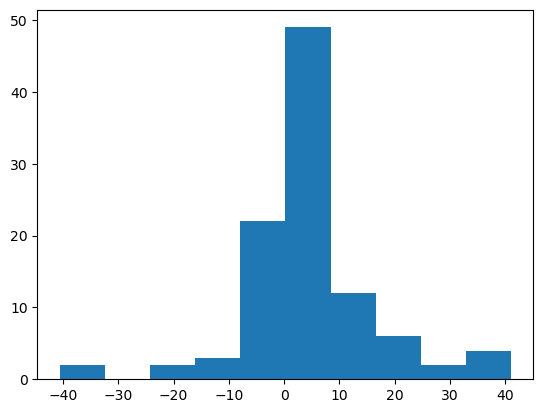

In [125]:
residuals = y_test_r-y_predicted_r
plt.hist(residuals)

(array([ 1.,  0.,  1., 51., 39.,  5.,  2.,  1.,  0.,  2.]),
 array([-29.50837309, -21.75536611, -14.00235914,  -6.24935216,
          1.50365482,   9.25666179,  17.00966877,  24.76267574,
         32.51568272,  40.26868969,  48.02169667]),
 <BarContainer object of 10 artists>)

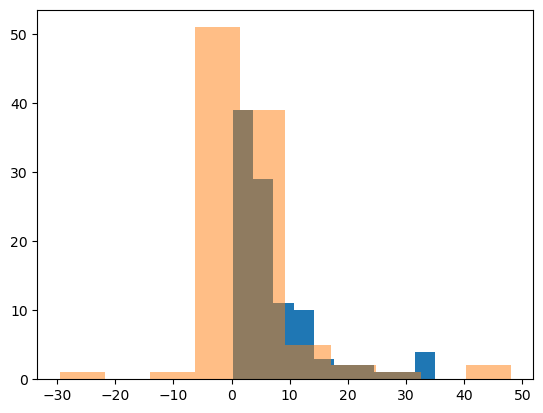

In [111]:
plt.hist(y_test_r)
plt.hist(y_predicted_r,alpha=0.5)

In [113]:
y_predicted_r.shape

(102,)

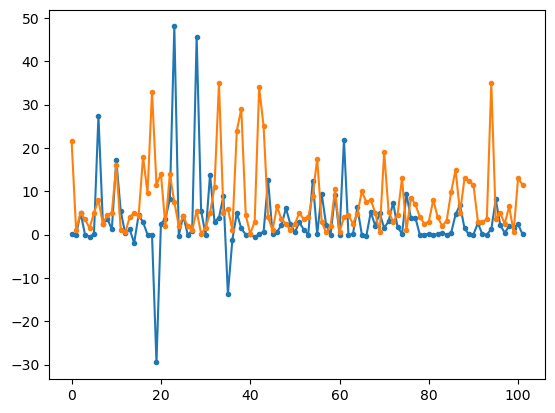

In [124]:
plt.plot(y_predicted_r, '.-')
plt.plot(y_test_r.to_numpy(),'.-')
#plt.ylim(-1000,1000)

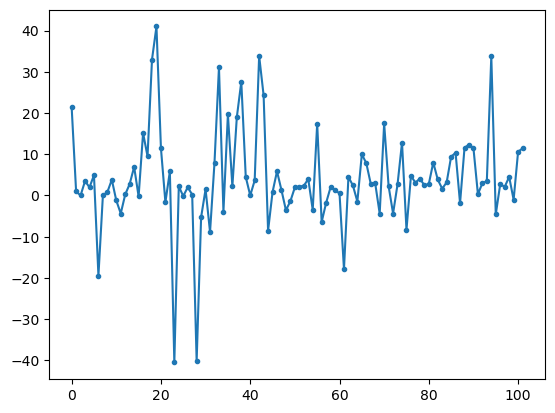

In [131]:
plt.plot(residuals.to_numpy(), '.-');
